# Static modular analysis

# Step 0:  Loading libraries
--------------------------------

In [2]:
# Load packages
%matplotlib inline

import sys
sys.path.append("..")
import os

import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

#---- matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'


import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
# Code can be found here: https://python-louvain.readthedocs.io/en/latest/api.html #community.best_partition

import statistics
import random
from collections import Counter

# follow permutation method here: https://medium.com/analytics-vidhya/permutation-test-as-an-alternative-to-two-sample-t-test-using-r-9f5da921bc95


# Step 1: Compute communities via Louvain algorithm (inc calculating modularity)

In [6]:
# Load data
mat_f = sio.loadmat('../../Data/06-Sex_analyses/01-Adjacency_matrices/Females_adj_matrices.mat')
female_adj = mat_f['Females_adj_matrices']
mat_m = sio.loadmat('../../Data/06-Sex_analyses/01-Adjacency_matrices/Males_adj_matrices.mat')
male_adj = mat_m['Males_adj_matrices']

In [7]:
n_sub = 15 # number of subjects per group
n_roi = 98
n_freq = 6

# Form graphs
assigned_systems_f = np.zeros((n_sub,n_roi,n_freq))
assigned_systems_m = np.zeros((n_sub,n_roi,n_freq))

modularity_f = np.zeros((n_sub,n_freq))
modularity_m = np.zeros((n_sub,n_freq))

for sub in range(n_sub):
    print(sub)
    for freq in range(n_freq):
        # Convert matrix to a networkx graph (f+m)
        Female_mat_plot = female_adj[:,:,freq,sub]
        Male_mat_plot = male_adj[:,:,freq,sub]
        
        D_f = nx.Graph(Female_mat_plot)
        D_m = nx.Graph(Male_mat_plot)

        # compute the best partition and store the assigned systems in new array
        partition_f = community_louvain.best_partition(D_f)
        partition_m = community_louvain.best_partition(D_m)
        
        # Compute modularity of selected partition
        modularity_f[sub,freq] = community_louvain.modularity(partition_f, D_f)
        modularity_m[sub,freq] = community_louvain.modularity(partition_m, D_m)
        
        
        # Assign system
        system_affiliation_f = list(partition_f.values())
        system_affiliation_m = list(partition_m.values())
        
        assigned_systems_f[sub,:,freq] = system_affiliation_f
        assigned_systems_m[sub,:,freq] = system_affiliation_m
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


# Step 2: Calculating NMI of networks

In [14]:
def NMI_func(A, B):
    # Note number of comunities in female and male partitions
    C_F = len(np.unique(A))
    C_M = len(np.unique(B))

    # Form N_i and N_j and store as array
    N_i = np.fromiter(Counter(A).values(), dtype=float)
    N_j = np.fromiter(Counter(B).values(), dtype=float)

    # Fill in N_ij
    N_ij = np.zeros((C_F,C_M))
    for i in range(C_F):
        for j in range(C_M):
            A_i = ((A == i))*1
            B_j = (B == j)*1
            N_ij[i,j] = sum(np.multiply(A_i,B_j))
    
    # Numerator
    num_sum = 0
    for i in range(C_F):
        for j in range(C_M):
            if N_ij[i,j] != 0:
                num_sum = num_sum + N_ij[i,j]*np.log((98*N_ij[i,j])/(N_i[i]*N_j[j]))
        
    num = -2* num_sum
    
    # Denominator
    den = sum(N_i*np.log(N_i/n_roi)) + sum(N_j*np.log(N_j/n_roi))
    
    
    nim = num / den
    
    return nim

In [15]:
# Here we calculate the NMI between all 30 subjects
assigned_system_all = np.concatenate((assigned_systems_f, assigned_systems_m), axis=0) # join subject data
n_sub = 30

nmi_within_all = np.zeros((n_sub,n_sub,n_freq))
nmi_within_all_mean = np.zeros((n_freq))

for freq in range(n_freq):
    for sub1 in range(n_sub):
        for sub2 in range(n_sub):
            subject_comm1 = assigned_system_all[sub1,:,freq]
            subject_comm2 = assigned_system_all[sub2,:,freq]
            
            nmi_within_all[sub1,sub2,freq] = NMI_func(subject_comm1,subject_comm2)
    
    np.fill_diagonal(nmi_within_all[:,:,freq], 0)
    nmi_within_all_mean[freq] = sum(sum(nmi_within_all[:,:,freq])) / (n_sub*(n_sub-1))#.shape
    
print(nmi_within_all_mean)

[0.68048829 0.67667616 0.69449454 0.69744477 0.6663595  0.61369826]


# Step 3: Comparing networks of different frequency bands

In [16]:
n_freq = 6
n_sub = 30
nmi_freq_bands = np.zeros((n_sub, n_sub, n_freq,n_freq))

for freq1 in range(n_freq):
    print(freq1)
    for freq2 in range(n_freq):
        for sub1 in range(n_sub):
            for sub2 in range(n_sub):
                nmi_comp_1 = assigned_system_all[sub1,:,freq1]
                nmi_comp_2 = assigned_system_all[sub2,:,freq2]
        
                nmi_freq_bands[sub1, sub2, freq1,freq2] = NMI_func(nmi_comp_1,nmi_comp_2)
        

print(nmi_freq_bands.shape)


0
1
2
3
4
5
(30, 30, 6, 6)


(6, 6)
[[0.69113868 0.67371769 0.68505971 0.68470975 0.66313356 0.63085378]
 [0.67371769 0.68745362 0.68694904 0.68810531 0.65853218 0.62577428]
 [0.68505971 0.68694904 0.70467805 0.69768515 0.66854373 0.6366526 ]
 [0.68470975 0.68810531 0.69768515 0.70752994 0.67637863 0.64344249]
 [0.66313356 0.65853218 0.66854373 0.67637863 0.67748085 0.64132046]
 [0.63085378 0.62577428 0.6366526  0.64344249 0.64132046 0.62657498]]


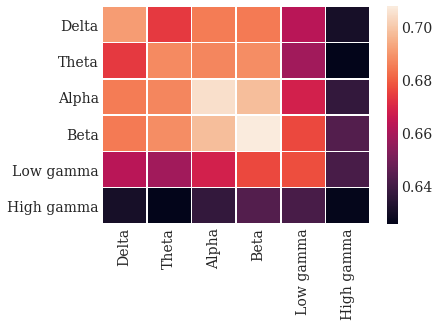

In [17]:
# Plotting settings for heatmap plot
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Mean over 30 x 30 subject matrices
nmi_freq_bands_mean = (nmi_freq_bands.mean(axis=0)).mean(axis=0)
print(nmi_freq_bands_mean.shape)
print(nmi_freq_bands_mean)

freq_band_list = ['Delta','Theta','Alpha','Beta','Low gamma','High gamma']

ax = sns.heatmap(nmi_freq_bands_mean, linewidth = 0.5,xticklabels = freq_band_list, yticklabels = freq_band_list)
#plt.title('Mean NMI between frequency bands')
plt.show()

# Step 4: ANOVA and Tukey test for comparing mean modularity of each frequency band

In [20]:
### We do two methods just to check results
### see https://reneshbedre.github.io/blog/anova.html
### Method (i)
modularity_store = np.concatenate((modularity_f, modularity_m))

import researchpy as rp
from scipy.stats import f_oneway
#print(rp.summary_cont(d))

stats.f_oneway(modularity_store[:,0],modularity_store[:,1],modularity_store[:,2],modularity_store[:,3],modularity_store[:,4],modularity_store[:,5])


F_onewayResult(statistic=60.08207747833361, pvalue=4.017197966289734e-36)

In [21]:
### Method (ii)
d = pd.DataFrame(modularity_store, columns=["Delta", "Theta", "Alpha", "Beta", "Low gamma", "High gamma"])
#d.boxplot(column=["Delta", "Theta", "Alpha", "Beta", "Low gamma", "High gamma"], grid=False)

import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d['Delta'], d['Theta'], d['Alpha'], d['Beta'],d['Low gamma'],d['High gamma'])
print(fvalue, pvalue)
# 17.492810457516338 2.639241146210922e-05

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=["Delta", "Theta", "Alpha", "Beta", "Low gamma", "High gamma"])
# replace column names
d_melt.columns = ['Subjects', 'Frequency_band', 'value']
print(d_melt)

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(Frequency_band)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# The p-value obtained from ANOVA analysis is significnat (p<0.0001) and, therefore, we conclude that there are
# significant differences among the means of the frequency bands


60.08207747833361 4.017197966289734e-36
     Subjects Frequency_band     value
0           0          Delta  0.734091
1           1          Delta  0.718500
2           2          Delta  0.722278
3           3          Delta  0.693696
4           4          Delta  0.708888
..        ...            ...       ...
175        25     High gamma  0.563281
176        26     High gamma  0.595571
177        27     High gamma  0.594161
178        28     High gamma  0.619913
179        29     High gamma  0.574066

[180 rows x 3 columns]


,sum_sq,df,F,PR(>F)
C(Frequency_band),0.289010,5.0,60.082077,4.017198e-36
Residual,0.167397,174.0,NaN,NaN


In [22]:
### Now we pairwise compare all the frequency bands
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='Frequency_band')
print(m_comp)

             A           B   mean(A)   mean(B)      diff        se          T  \
0        Alpha        Beta  0.730829  0.730624  0.000206  0.008009   0.025680   
1        Alpha       Delta  0.730829  0.713904  0.016925  0.008009   2.113416   
2        Alpha  High gamma  0.730829  0.625793  0.105037  0.008009  13.115620   
3        Alpha   Low gamma  0.730829  0.665397  0.065433  0.008009   8.170388   
4        Alpha       Theta  0.730829  0.729171  0.001658  0.008009   0.207026   
5         Beta       Delta  0.730624  0.713904  0.016720  0.008009   2.087737   
6         Beta  High gamma  0.730624  0.625793  0.104831  0.008009  13.089941   
7         Beta   Low gamma  0.730624  0.665397  0.065227  0.008009   8.144709   
8         Beta       Theta  0.730624  0.729171  0.001452  0.008009   0.181346   
9        Delta  High gamma  0.713904  0.625793  0.088112  0.008009  11.002204   
10       Delta   Low gamma  0.713904  0.665397  0.048507  0.008009   6.056972   
11       Delta       Theta  

/Users/bengriffin/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Step 5: ANOVA and Tukey test for comparing NMI of each frequency band

In [23]:
n_freq = 6
nmi_store = np.zeros((435,n_freq))
print(nmi_store.shape)
print(nmi_within_all.shape)


for freq in range(n_freq):
    nmi_mean = sum(sum(np.triu(nmi_within_all[:,:,freq])) / ((n_sub*(n_sub-1))/2))
    nmi_vec = np.triu(nmi_within_all[:,:,freq]).flatten()
    nmi_vec_clean = nmi_vec[nmi_vec != 0]
    nmi_store[:,freq] = nmi_vec_clean
    print(nmi_mean)
    

(435, 6)
(30, 30, 6)
0.6804882919580723
0.6766761550227893
0.6944945372831974
0.6974447653111039
0.6663595035646406
0.6136982585030999


In [24]:
d2 = pd.DataFrame(nmi_store, columns=["Delta", "Theta", "Alpha", "Beta", "Low gamma", "High gamma"])

print(rp.summary_cont(d2))
stats.f_oneway(nmi_store[:,0],nmi_store[:,1],nmi_store[:,2],nmi_store[:,3],nmi_store[:,4],nmi_store[:,5])



     Variable      N    Mean      SD      SE  95% Conf.  Interval
0       Delta  435.0  0.6805  0.0575  0.0028     0.6751    0.6859
1       Theta  435.0  0.6767  0.0606  0.0029     0.6710    0.6824
2       Alpha  435.0  0.6945  0.0523  0.0025     0.6896    0.6994
3        Beta  435.0  0.6974  0.0531  0.0025     0.6924    0.7024
4   Low gamma  435.0  0.6664  0.0634  0.0030     0.6604    0.6723
5  High gamma  435.0  0.6137  0.0804  0.0039     0.6061    0.6213


F_onewayResult(statistic=106.09798549042807, pvalue=3.5432554841185817e-102)

In [25]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d2['Delta'], d2['Theta'], d2['Alpha'], d2['Beta'],d2['Low gamma'],d2['High gamma'])
print(fvalue, pvalue)

106.09798549042807 3.5432554841185817e-102


### Tukey test

In [26]:
d2_melt = pd.melt(d2.reset_index(), id_vars=['index'], value_vars=["Delta", "Theta", "Alpha", "Beta", "Low gamma", "High gamma"])
# replace column names
d2_melt.columns = ['Subjects', 'Frequency_band', 'value']
m2_comp = pairwise_tukey(data=d2_melt, dv='value', between='Frequency_band')
print(m2_comp)

             A           B   mean(A)   mean(B)      diff        se          T  \
0        Alpha        Beta  0.694495  0.697445 -0.002950  0.004199  -0.702585   
1        Alpha       Delta  0.694495  0.680488  0.014006  0.004199   3.335533   
2        Alpha  High gamma  0.694495  0.613698  0.080796  0.004199  19.241318   
3        Alpha   Low gamma  0.694495  0.666360  0.028135  0.004199   6.700248   
4        Alpha       Theta  0.694495  0.676676  0.017818  0.004199   4.243378   
5         Beta       Delta  0.697445  0.680488  0.016956  0.004199   4.038118   
6         Beta  High gamma  0.697445  0.613698  0.083747  0.004199  19.943903   
7         Beta   Low gamma  0.697445  0.666360  0.031085  0.004199   7.402833   
8         Beta       Theta  0.697445  0.676676  0.020769  0.004199   4.945963   
9        Delta  High gamma  0.680488  0.613698  0.066790  0.004199  15.905785   
10       Delta   Low gamma  0.680488  0.666360  0.014129  0.004199   3.364716   
11       Delta       Theta  

In [27]:
model = ols('value ~ C(Frequency_band)', data=d2_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Frequency_band),2.034462,5.0,106.097985,3.543255e-102
Residual,9.986501,2604.0,NaN,NaN
